In [2]:
!pip install geopandas
!pip install fiona
!pip install pandas
!pip install pyproj
!pip install os
!pip install shapely
!pip install unary_union

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 97.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
ERROR: Could not find a version that satisfies the requirement unary_union (from versions: none)
ERROR: No matching distribution found for unary_union


In [3]:
import geopandas as gpd
import fiona
import pandas as pd
import pyproj
import os
from shapely.geometry import shape
from shapely.ops import split, unary_union

In [4]:
import time

def time_it(func):
    """
    A decorator function to measure the execution time of a given function.

    Args:
        func: The function whose execution time needs to be measured.

    Returns:
        A wrapped version of the input function that prints the execution time.
    """
    def wrapper(*args, **kwargs):
        # Record the start time
        start_time = time.time()

        # Call the original function with its arguments
        result = func(*args, **kwargs)

        # Record the end time
        end_time = time.time()

        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        print(f"Function '{func.__name__}' took {elapsed_time:.6f} seconds to execute.")

        # Return the result of the original function
        return result

    return wrapper


In [5]:
pd.set_option('display.max_columns', None)


In [6]:
muni_df = gpd.read_file("MunicipalitiesRegion.tab", driver='MapInfo File') # Explicitly specify the MapInfo File driver

In [7]:
muni_df = muni_df[muni_df['PROV']=="AB"].sort_values('NAME')

In [8]:
model_area_lut = muni_df[['UNIQUE_ID','NAME','PROV','geometry']]
model_area_lut.shape

(425, 4)

In [10]:
model_areas = gpd.read_file("ModelAreas_AB.TAB", driver='MapInfo File')

In [11]:
model_area_lut['Obj_Npolygons'] = model_area_lut.geometry.apply(lambda g: 1 if g.geom_type == "Polygon" else len(g.geoms))



/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [12]:
df = model_area_lut[model_area_lut['Obj_Npolygons']>1]

In [13]:
df.shape

(16, 5)

In [14]:
multi_polys = model_area_lut[model_area_lut['Obj_Npolygons']>1]
multi_polys

,UNIQUE_ID,NAME,PROV,geometry,Obj_Npolygons
4155,480004283.0,Big Lakes County,AB,"MULTIPOLYGON (((-115.42926 55.33446, -115.4293...",3
4132,480004244.0,Bighorn No. 8,AB,"MULTIPOLYGON (((-115.0409 51.08535, -115.04148...",3
4065,480004172.0,Bonnyville No. 87,AB,"MULTIPOLYGON (((-110.23005 54.33312, -110.2390...",2
3845,480003944.0,Cardston County,AB,"MULTIPOLYGON (((-112.82355 49.5651, -112.82347...",3
3939,480004040.0,Daysland,AB,"MULTIPOLYGON (((-112.26333 52.87505, -112.2657...",2
3916,480004016.0,Eden Valley 216,AB,"MULTIPOLYGON (((-114.437 50.4263, -114.41432 5...",2
4237,480006955.0,Loon Lake 235,AB,"MULTIPOLYGON (((-115.43143 56.46439, -115.4208...",2
3980,480004083.0,O'Chiese 203,AB,"MULTIPOLYGON (((-115.28136 52.71262, -115.2808...",2
3859,480003959.0,Piikani 147,AB,"MULTIPOLYGON (((-113.79562 49.55309, -113.8069...",2
3851,480003950.0,Pincher Creek No. 9,AB,"MULTIPOLYGON (((-113.71651 49.65489, -113.7165...",2


In [15]:
multi_polys = multi_polys.explode(index_parts = False).reset_index(drop=True)

In [17]:
multi_polys = multi_polys.sjoin(model_areas[['ModelAreaName','geometry']],how='left',predicate='intersects')

In [22]:
multi_polys['TempName'] = multi_polys['ModelAreaName']+"_"+multi_polys['NAME']

In [24]:
merged = multi_polys.dissolve(by='TempName',as_index = False)

In [27]:
merged = merged[['UNIQUE_ID','NAME','PROV','ModelAreaName','geometry']]

In [28]:
model_area_lut = pd.concat([model_area_lut[model_area_lut['Obj_Npolygons']==1],merged],ignore_index=True)

In [29]:
model_area_lut= model_area_lut.drop(columns=['Obj_Npolygons'])

In [30]:
model_area_lut

,UNIQUE_ID,NAME,PROV,geometry,ModelAreaName
0,480003962.0,Acadia No. 34,AB,"POLYGON ((-110.00516 51.27035, -110.00516 51.2...",NaN
1,480003992.0,Acme,AB,"POLYGON ((-113.49754 51.49567, -113.4975 51.50...",NaN
2,480004006.0,Airdrie,AB,"POLYGON ((-113.98012 51.32894, -113.98476 51.3...",NaN
3,480004209.0,Alberta Beach,AB,"POLYGON ((-114.37018 53.66819, -114.37019 53.6...",NaN
4,480004169.0,Alexander 134,AB,"POLYGON ((-114.04118 53.77305, -114.03071 53.7...",NaN
...,...,...,...,...,...
428,480006955.0,Loon Lake 235,AB,"MULTIPOLYGON (((-115.43421 56.46436, -115.4329...",SlaveLake
429,480004307.0,Sawridge 150G,AB,"MULTIPOLYGON (((-114.6685 55.2868, -114.66843 ...",SlaveLake
430,480004306.0,Swan River 150E,AB,"MULTIPOLYGON (((-115.38607 55.35306, -115.3860...",SlaveLake
431,480004170.0,Wabamun 133A,AB,"MULTIPOLYGON (((-114.30882 53.497, -114.30875 ...",SpruceGrove


In [20]:
model_areas.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [21]:
outside_polygons = multi_polys[multi_polys['ModelAreaName'].isna()]

# Prep Munc Function

In [36]:
@time_it
def prep_muni(df_muni,model_area_df,prov):
  muni_df = df_muni[df_muni['PROV']==prov].sort_values('NAME')
  model_area_lut = muni_df[['UNIQUE_ID','NAME','PROV','geometry']]

  if prov == "BC":
    pass

  model_areas = model_area_df
  model_area_lut['Obj_Npolygons'] = model_area_lut.geometry.apply(lambda g: 1 if g.geom_type == "Polygon" else len(g.geoms))
  multi_polys = model_area_lut[model_area_lut['Obj_Npolygons']>1]
  multi_polys = multi_polys.explode(index_parts = False).reset_index(drop=True)
  multi_polys = multi_polys.sjoin(model_areas[['ModelAreaName','geometry']],how='left',predicate='intersects')
  multi_polys['TempName'] = multi_polys['ModelAreaName']+"_"+multi_polys['NAME']
  merged = multi_polys.dissolve(by='TempName',as_index = False)
  merged = merged[['UNIQUE_ID','NAME','PROV','ModelAreaName','geometry']]
  model_area_lut = pd.concat([model_area_lut[model_area_lut['Obj_Npolygons']==1],merged],ignore_index=True)
  model_area_lut= model_area_lut.drop(columns=['Obj_Npolygons'])
  model_area_lut.to_file("ModelAreaLUT", driver="MapInfo File")
  print("Municipality lookup table created for Alberta (AB) in MapInfo TAB format at")
  return model_area_lut



In [37]:
muni_df = gpd.read_file("MunicipalitiesRegion.tab", driver='MapInfo File') # Explicitly specify the MapInfo File driver
prov_list = ["AB"]
for prov in prov_list:
  model_areas = gpd.read_file(f"ModelAreas_{prov}.TAB", driver='MapInfo File')
  model_area_lut = prep_muni(muni_df,model_areas,prov)


Municipality lookup table created for Alberta (AB) in MapInfo TAB format at
Function 'prep_muni' took 0.135369 seconds to execute.


/usr/local/lib/python3.11/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Plot Map
Check which area fall outside the

<ipython-input-71-827b568daff1>:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
<ipython-input-71-827b568daff1>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


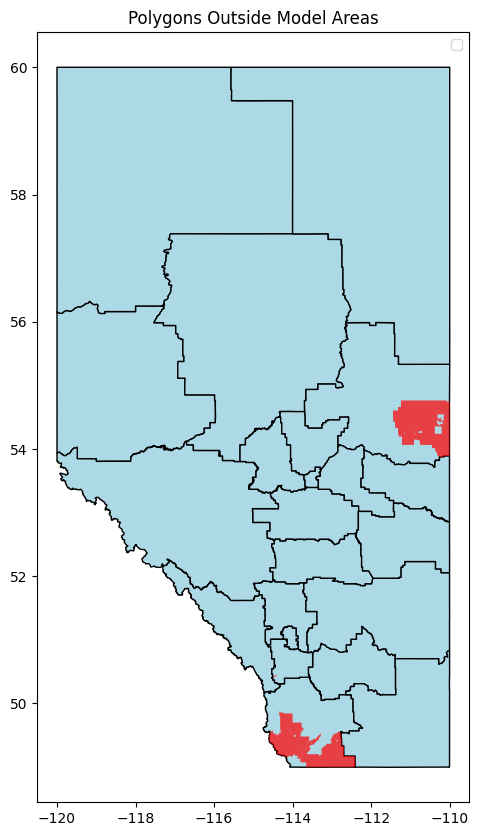

In [ ]:
import matplotlib.pyplot as plt

# Plot the model_areas
fig, ax = plt.subplots(figsize=(10, 10))
model_areas.plot(ax=ax, color='lightblue', edgecolor='black', label='Model Areas')

# Plot the outside polygons
outside_polygons.plot(ax=ax, color='red', alpha=0.7, label='Outside Polygons')

# Add legend and title
plt.legend()
plt.title('Polygons Outside Model Areas')
plt.show()

In [ ]:
print(model_areas.is_valid.all())

True


# Convert MAPinfo file to jeoson


In [ ]:
import geopandas as gpd

# Read the .TAB file
tab_file = "/content/BoundaryUpgradeLog.TAB"
gdf = gpd.read_file(tab_file)

# Convert to GeoJSON
geojson_file = "output.geojson"
gdf.to_file(geojson_file, driver="GeoJSON")

print(f"GeoJSON file saved to {geojson_file}")


GeoJSON file saved to output.geojson


# Create a map with Layers in Folium

In [ ]:
import folium
import json

# Create a map centered around a specific location
m = folium.Map(location=[45.4215, -75.6972], zoom_start=13)

# Open the GeoJSON file and load the data using json.load()
with open("/content/output.geojson") as f:
    geojson = json.load(f)

# Add the GeoJSON layer (boundary layer)
folium.GeoJson(geojson, name='Boundary Layer').add_to(m)

# Add layer control to toggle the boundary layer
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('map_with_geojson.html')
